In [5]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items') # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Admin123$',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = r'H:/Data Analytics project/Ecommerce Datasets'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db= mysql.connector.connect(host="localhost", username="root", password="Admin123$", database="ecommerce")
cur=db.cursor()


In [55]:
#1. List all unique cities where customers are located.
query='''select distinct customer_city from customers'''
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df.head()


,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


In [36]:
#2Count the number of orders placed in 2017.
query='''select count(order_id) from orders where year(order_purchase_timestamp)=2017'''
cur.execute(query)
data=cur.fetchall()
"total orders placed  in 2017 are",data[0][0]

('total orders placed  in 2017 are', 90202)

In [37]:
#3Find the total sales per category.
query='''select products.product_category category, round(sum(payments.payment_value),2)sales
from products join order_items on products.product_id=order_items.product_id 
join payments on payments.order_id=order_items.order_id
group by category'''
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["Category", "Sales"])
df

,Category,Sales
0,perfumery,4053909.28
1,Furniture Decoration,11441411.13
2,telephony,3895056.41
3,bed table bath,13700429.37
4,automotive,6818354.65
...,...,...
69,cds music dvds,9595.44
70,La Cuisine,23308.24
71,Fashion Children's Clothing,6285.36
72,PC Gamer,17395.44


In [38]:
#4. Calculate the percentage of orders that were paid in installments.

query='''select (sum(case when payment_installments>=1 then 1 
else 0 end))/count(*)*100 from payments'''
cur.execute(query)
data=cur.fetchall()
"the percentage of orders that were paid in installments is", data[0][0]



('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

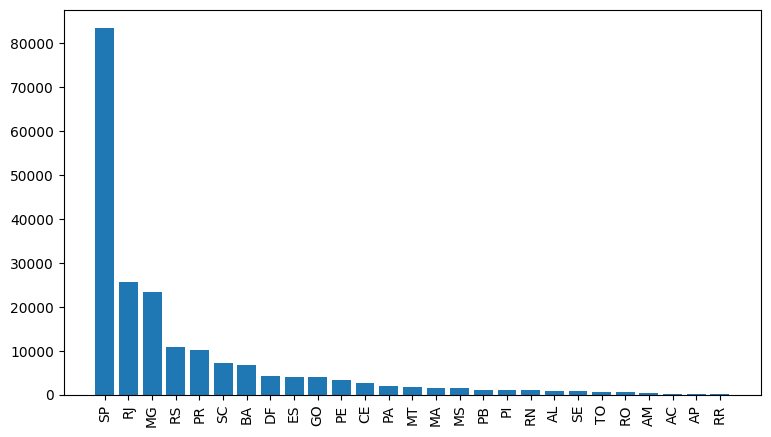

In [54]:
#5. Count the number of customers from each state. 

query='''select customer_state,count(customer_id)
from customers group by customer_state'''
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["state","customer_count"])
df=df.sort_values(by= 'customer_count',ascending=False)
plt.figure(figsize=(9,5))
plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation=90)

plt.show()

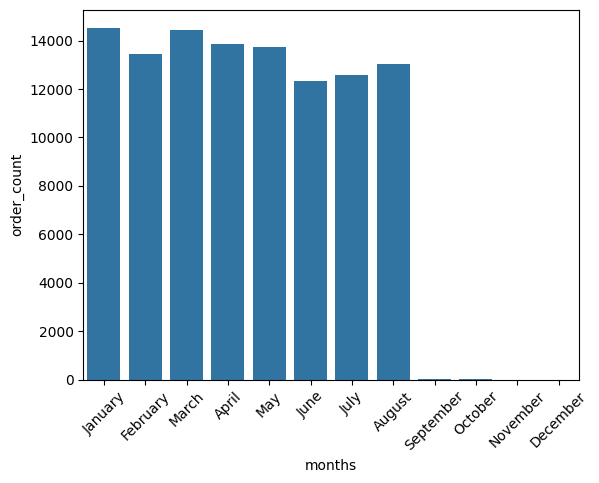

In [60]:
#1. Calculate the number of orders per month in 2018.
query='''select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp)=2018
group by months'''
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["months","order_count"])
O=["January","February","March","April","May","June","July","August","September","October","November","December"]
sns.barplot(x=df["months"], y=df["order_count"], data=df,order=O)
plt.xticks(rotation=45)
plt.show()